Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np # import cupy when running on gpu
import os
from skimage import io
import matplotlib.pyplot as plt
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
import torch.nn.functional as F
!pip install torchinfo
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
import functools
import itertools
import numpy
import operator
import cv2
import time
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

Consts

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
NUM_IMAGES = 6334
NUM_EPOCHS = 40
BATCH_SIZE = 128
LEARNING_RATE = 0.01
OUTPUT_DIM = 3
IMG_SIZE = 224
NUM_FOLDS = 5
#PADDING_SIZE = ?

cuda


Functions

In [ ]:
def plot_measure(results_train, results_val, measure, output_dir):
    plt.rcParams["figure.figsize"] = (8,8)
    plt.plot(results_train)
    plt.plot(results_val)
    plt.xlim(-0.2)
    plt.xlabel('Epochs')
    plt.ylabel(measure)
    if measure == 'acc':
        plt.legend(['Train', 'Validation'], loc='upper left')
    if measure == 'loss':
        plt.legend(['Train', 'Validation'], loc='upper right')
    plt.title(measure)
    #plt.savefig(f'{output_dir}{measure}.jpeg')
    plt.show()
    plt.close()

In [ ]:
def load_images_from_folder(path, num_images):
    """
    returns list of tuples of shape: num_images x (image_name, img_arr) 
    params: 
        path = folder path of the images
        num_images = number of images to load
    """
    images_rep = np.zeros(shape=(NUM_IMAGES, IMG_SIZE, IMG_SIZE))
    images_name = [0 for i in range(NUM_IMAGES)]
    for i, filename in enumerate(os.listdir(path)):
        if i%500==0:
            print(i)
        # filename structure is: <studyinstanceuid>_<some text>_<imageinstanceuid>.jpg
        img_name = filename.split('_')[2].split('.')[0]
        if i==num_images:
            break
        #img = np.array(io.imread(os.path.join(path,filename)) > 125).astype(int) # black & white norm
        img = np.array(io.imread(os.path.join(path,filename))) #/ 255 # regular norm
        if img is not None:
            images_rep[i] = img
            images_name[i] = img_name
    return images_rep, images_name

images_rep, images_name = load_images_from_folder('/content/drive/MyDrive/images/final project/224px/train/train', NUM_IMAGES)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000


[[ 48.  37.  22. ...  88. 102. 124.]
 [ 19.  13.   4. ...  50.  63.  81.]
 [  2.   0.   0. ...  11.  18.  30.]
 ...
 [ 45.  28.   8. ...  10.  13.  15.]
 [ 46.  34.  18. ...  31.  33.  35.]
 [ 58.  49.  35. ...  58.  60.  62.]]


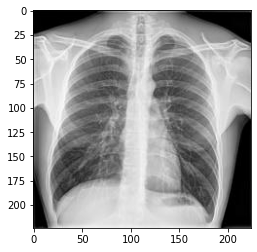

In [ ]:
print(images_rep[0])
plt.imshow(images_rep[0], cmap='gray')
plt.show()

In [ ]:
train_excel = pd.read_csv('/content/drive/MyDrive/images/final project/train.csv')#, sep='\t')
print(train_excel.iloc[3, 3])
train_excel = train_excel.replace(to_replace=3, value=2)
print(train_excel.iloc[3, 3])

x = np.array(train_excel['study_label'])
img_name_to_label = pd.Series(data=x, index=train_excel['ImageInstanceUID'])

labels = [0 for i in range(NUM_IMAGES)]
for i in range(NUM_IMAGES):
    labels[i] = img_name_to_label[images_name[i]]

print(images_rep.shape)
X_percp = images_rep.reshape((6334, 50176))
print(X_percp.shape)

3
2
(6334, 224, 224)
(6334, 50176)


In [ ]:
# reshaping for perceptron input
perceptron = Perceptron()
perceptron.fit(X_percp, labels)
perceptron.score(X_percp, labels)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:

"""
X_train, X_val, y_train, y_val = train_test_split(tensor_images, labels, test_size=0.2, random_state=42)
del tensor_images
del labels

train_dataset = TensorDataset(X_train, y_train)
del X_train
del y_train
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
del train_dataset

val_dataset = TensorDataset(X_val, y_val)
del X_val
del y_val
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
del val_dataset
"""

'\nX_train, X_val, y_train, y_val = train_test_split(tensor_images, labels, test_size=0.2, random_state=42)\ndel tensor_images\ndel labels\n\ntrain_dataset = TensorDataset(X_train, y_train)\ndel X_train\ndel y_train\ntrain_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)\ndel train_dataset\n\nval_dataset = TensorDataset(X_val, y_val)\ndel X_val\ndel y_val\nval_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)\ndel val_dataset\n'

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
my_model = AlexNet(3)
print(summary(my_model))
print(my_model)

Layer (type:depth-idx)                   Param #
AlexNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       7,808
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       307,392
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       663,936
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       884,992
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      590,080
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─AdaptiveAvgPool2d: 1-2                 --
├─Sequential: 1-3                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      37,752,832
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                    

In [ ]:
#handeling the imbalanced problem
weights = torch.tensor([1736, 3007, 1491], dtype=torch.float32).cuda()
weights = weights / weights.sum()
#print(weights)
weights = 1.0 / weights
weights = weights / weights.sum()
#print(weights)

criterion = nn.CrossEntropyLoss(weight=weights)
#criterion = nn.CrossEntropyLoss()
#my_model.apply(initialize_weights)

train_acc = np.zeros(shape=(NUM_FOLDS, NUM_EPOCHS))
train_loss = np.zeros(shape=(NUM_FOLDS, NUM_EPOCHS))
val_acc = np.zeros(shape=(NUM_FOLDS, NUM_EPOCHS))
val_loss = np.zeros(shape=(NUM_FOLDS, NUM_EPOCHS))
times_folds = []
confusion_matrices = []

tensor_images = torch.from_numpy(images_rep)
tensor_images = tensor_images.view(tensor_images.shape[0], 1, IMG_SIZE, IMG_SIZE).float()
print(tensor_images.shape)
print()
labels = torch.tensor(labels)

skf = StratifiedKFold(n_splits=5, random_state=40, shuffle=True)
for i, (train_index, test_index) in enumerate(skf.split(tensor_images, labels)):
    print(f'fold num: {i+1}')
    #print("TRAIN:", train_index, "Val:", test_index)
    print()
    
    X_train, X_val = tensor_images[train_index], tensor_images[test_index]
    y_train, y_val = labels[train_index], labels[test_index]
    
    print(np.array(torch.bincount(y_train))/len(y_train))
    print(np.array(torch.bincount(y_val))/len(y_val))
    
    train_dataset = TensorDataset(X_train, y_train)
    del X_train
    del y_train
    train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    del train_dataset
    
    val_dataset = TensorDataset(X_val, y_val)
    del X_val
    del y_val
    val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    del val_dataset
    
    my_model=AlexNet(3)
    optimizer = optim.SGD(my_model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)
    my_model.to(device)
    
    y_true = []
    y_pred = []
    
    t = time.time()
    for epoch in range(NUM_EPOCHS):
        my_model.train()
        running_loss = 0.0
        correct = 0
        print(f'epoch: {epoch+1}')
        for batch_num, (inputs, label) in enumerate(train_loader, start=1):
            #print(batch_num)
            inputs, label = inputs.to(device), label.to(device)
            optimizer.zero_grad()
            output = my_model(inputs)
            #break
            #print(output)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            outputs_max_inds = torch.argmax(output, axis=1)
            #print(outputs_max_inds)
            #print(label)
            correct += torch.sum(torch.eq(outputs_max_inds, label))
        #break
        acc = 100*(correct.item()/len(train_loader.dataset))
        loss = running_loss/batch_num
        train_acc[i, epoch] = acc
        train_loss[i, epoch] = loss
        print(f"Train loss: {loss:.3f}, Train accuracy: {acc:.3f}%")
        my_model.eval()
        running_loss = 0.0
        correct = 0
        for batch_num, (inputs, label) in enumerate(val_loader, start=1):
            inputs, label = inputs.to(device), label.to(device)
            output = my_model(inputs)
            outputs_max_inds = torch.argmax(output, axis=1)
            if epoch + 1 == NUM_EPOCHS:
                for elem in label:
                    y_true.append(elem.item())
                for elem in outputs_max_inds:
                    y_pred.append(elem.item())
            loss = criterion(output, label)
            running_loss += loss.item()
            correct += torch.sum(torch.eq(outputs_max_inds, label))
        acc = 100*(correct.item()/len(val_loader.dataset))
        loss = running_loss/batch_num
        val_acc[i, epoch] = acc
        val_loss[i, epoch] = loss
        print(f"Val loss: {loss:.3f}, Val accuracy: {acc:.3f}%")
    train_time = (time.time() - t) / 60
    times_folds.append(train_time)
    confusion_matrices.append(confusion_matrix(y_true, y_pred, labels=[0, 1, 2]))
    print()

print(f'training took: {np.mean(times_folds)} mintues \n\n')
avg_train_acc = np.mean(train_acc, axis=0)
avg_val_acc = np.mean(val_acc, axis=0)
print(f'train acc is: {avg_train_acc[-1]}\n')
print(f'val acc is: {avg_val_acc[-1]}\n')
plot_measure(avg_train_acc, avg_val_acc, 'acc', "")
print('\n\n')
avg_train_loss = np.mean(train_loss, axis=0)
avg_val_loss = np.mean(val_loss, axis=0)
print(f'train loss is: {avg_train_loss[-1]}\n')
print(f'val loss is: {avg_val_loss[-1]}\n')
plot_measure(avg_train_loss, avg_val_loss, 'loss', "")
print('\n\n')
print(np.mean(confusion_matrices, axis=0).astype(int))

torch.Size([6334, 1, 224, 224])

fold num: 1

[0.2741267  0.47463983 0.25123347]
[0.2738753  0.47513812 0.25098658]
epoch: 1
Train loss: 1.118, Train accuracy: 31.064%
Val loss: 1.100, Val accuracy: 43.567%
epoch: 2
Train loss: 1.089, Train accuracy: 33.235%
Val loss: 1.064, Val accuracy: 44.830%
epoch: 3
Train loss: 1.062, Train accuracy: 44.247%
Val loss: 1.071, Val accuracy: 45.146%
epoch: 4
Train loss: 1.051, Train accuracy: 45.313%
Val loss: 1.053, Val accuracy: 44.594%
epoch: 5
Train loss: 1.032, Train accuracy: 48.845%
Val loss: 1.028, Val accuracy: 44.041%
epoch: 6
Train loss: 1.013, Train accuracy: 50.128%
Val loss: 1.059, Val accuracy: 47.830%
epoch: 7
Train loss: 1.019, Train accuracy: 48.806%
Val loss: 1.030, Val accuracy: 46.725%
epoch: 8
Train loss: 1.003, Train accuracy: 50.641%
Val loss: 1.020, Val accuracy: 49.487%
epoch: 9
Train loss: 0.983, Train accuracy: 51.964%
Val loss: 1.004, Val accuracy: 50.276%
epoch: 10
Train loss: 0.971, Train accuracy: 53.345%
Val loss: 0.

In [ ]:
"""
class cnn_network(nn.Module):
    def __init__(self, max_pool_out_dim, hidden_dim, output_dim):
        super(cnn_network, self).__init__()
        self.cnn_layer1 = nn.Conv2d(1, 96, kernel_size=11, stride=4)
        self.max_pool_layer1 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.cnn_layer2 = nn.Conv2d(96, 16, kernel_size=8, stride=2)

        self.cnn_layer3 = nn.Conv2d(16, 1, kernel_size=4, stride=1)
        #
        
        #self.cnn_layer4 = nn.Conv2d(64, 128, kernel_size=2, stride=2)

        #self.cnn_layer5 = nn.Conv2d(128, 4, kernel_size=2, stride=2)
        #self.max_pool_layer4 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.linear1 = nn.Linear(64, 32)
        self.linear2 = nn.Linear(32, 16)
        #self.linear3 = nn.Linear(256, 128)
        #self.linear4 = nn.Linear(128, 64)
        #self.linear5 = nn.Linear(64, 32)
        self.linear6 = nn.Linear(16, output_dim)
        self.act6 = nn.Softmax(dim=1)
        
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.cnn_layer1(x))
        #print(x.shape) 
        #x = F.max_pool2d(x, 2, stride=2)
        #print(x.shape)
        #x = F.max_pool2d(F.relu(self.cnn_layer2(x)), 2)
        x = F.relu(self.cnn_layer2(x))
        #x = F.max_pool2d(x, 4, stride=4)
        #print(x.shape)
        #x = self.max_pool_layer3(x)
        #print(x.shape)
        x = F.relu(self.cnn_layer3(x))
        #print(x.shape)
        #x = self.max_pool_layer4(x)
        #print(x.shape)
        #x = F.relu(self.cnn_layer4(x))
        #print(x.shape)
        #x = F.relu(self.cnn_layer5(x))
        #print(x.shape)
        x = F.max_pool2d(x, 2, stride=1)
        #print(x.shape)
        # flatten: 0 = batch_size, 1 = number of channels 2 = width, 3 = height
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        #print(x.shape)
        x = F.relu(self.linear1(x))
        #x = self.dropout(x)
        x = F.relu(self.linear2(x))
        #x = F.relu(self.linear3(x))
        #x = F.relu(self.linear4(x))
        #x = F.relu(self.linear5(x))
        #x = self.dropout(x)
        x = self.act6(self.linear6(x))
        #x = torch.softmax(self.linear3(x))
        return x

def initialize_weights(model):
    if type(model) in [nn.Linear]:
        nn.init.xavier_uniform_(model.weight)
        nn.init.zeros_(model.bias)
    #elif type(model) in [nn.Conv2d]:
        
        
my_model = cnn_network(16*16*128, 32, 3)
print(summary(my_model))
#my_model.apply(initialize_weights)
"""

Debugging

In [ ]:
"""
# NOT OUR CODE
my_model = cnn_network(45*45, 64, 4)
print(my_model)
optimizer = optim.Adam(my_model.parameters(), lr=LEARNING_RATE, eps=1e-07)
criterion = nn.CrossEntropyLoss()
my_model.train()
my_model.to(device)
for epoch in range(EPOCHS):
    outputs = []
    labels = []
    running_loss = 0.0
    correct = 0
    print(epoch)
    for batch_num, (inputs, label) in enumerate(data, start=1):
        print(batch_num)
        inputs, label = inputs.to(device), label.to(device)
        optimizer.zero_grad()
        output = my_model(inputs)
        for elem in label:
            labels.append(elem.item())
        #loss = criterion(output, label.view(BATCH_SIZE,-1))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        outputs_max_inds = torch.argmax(output, axis=1)
        correct += (torch.sum(outputs_max_inds == labels))
        print(correct)
    tn, fp, fn, tp = confusion_matrix(labels, outputs).ravel()
    acc = 100*correct/(len(data.dataset))
    loss = running_loss
    print(f"epoch num: {epoch} - Train loss: {loss:.3f}, Train accuracy: {acc:.3f}%")
    fpr, tpr, thresholds = metrics.roc_curve(labels, outputs)
    auc = metrics.auc(fpr, tpr)
    print(auc)
    plot_roc(tpr,fpr)
"""